In [1]:
import lucem_illud 

import pandas #gives us DataFrames
import numpy as np #For divergences/distances
import scipy #For divergences/ distances/ hierarchical clustering and some visuals

import nltk #the Natural Language Toolkit
from nltk.corpus import stopwords #For stopwords

import seaborn as sns #makes our plots look nicer
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import wordcloud #Makes word clouds

#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import sklearn.manifold #For a manifold plot

import gensim#For topic modeling

from bs4 import BeautifulSoup
import requests #for http requests
from requests import get
import urllib.parse #For joining urls
import re #for regexs
import json #For API responses

import itertools

%matplotlib inline

## Load Data Frame

In [2]:
ECONOMIST = pandas.read_csv('ECONOMIST_Token_Neat.csv')

In [3]:
ECONOMIST = ECONOMIST.drop(columns = ['Unnamed: 0'])

In [4]:
ECONOMIST[:6]

,Year,Month,Day,Title,Tag,Article,Token_Word,Remark_Index
0,2006,1,14,Nuclear proliferation Misreading Iran,Leaders,\n\t\t\tSpecial report Iran's nuclear programm...,"['Special', 'report', 'Iran', ""'s"", 'nuclear',...",31
1,2006,1,14,UN reform Fix it or scrap it,Leaders,\n\t\t\tMexico and the United States Shots acr...,"['Mexico', 'and', 'the', 'United', 'States', '...",58
2,2006,1,14,Spain and its regions A Catalan kerfuffle,Leaders,\n\t\t\tSpain and Catalonia Bad echoes from th...,"['Spain', 'and', 'Catalonia', 'Bad', 'echoes',...",45
3,2006,1,14,Walls and fences On America's southern border,Leaders,n.a.,"['n.a', '.']",n.a.
4,2006,1,14,Anti-social behaviour Soothing the savage breast,Britain,\n\t\t\tBritain\n\t\t\tAnti-social behaviour S...,"['Britain', 'Anti-social', 'behaviour', 'Sooth...",34
5,2006,1,14,George Galloway Big Blatherer,Britain,\n\t\t\tNo DeLay Time for a proper fight\n\t\t...,"['No', 'DeLay', 'Time', 'for', 'a', 'proper', ...",53


In [5]:
Topics = ['Leaders', 'Britain', 'Europe', 'United States', 'The Americas', 
              'Middle East and Africa', 'Asia', 'Obituary',
              'Business', 'Finance and economics', 'Science and technology', 'Books and arts']

years = ['2006','2007','2008','2009','2010']

category = ['Business', 'Finance and economics', 'Science and technology', 'Books and arts']

In [6]:
Economist = ECONOMIST
delete_topics = ['Leaders', 'Britain', 'Europe', 'United States', 'The Americas', 
              'Middle East and Africa', 'Asia', 'Obituary']
for dt in delete_topics:
    Economist = Economist[Economist.Tag != dt]

## Tf-idf

In [7]:
# Count Vectorizer
EconomistCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
EconomistVects = EconomistCountVectorizer.fit_transform(Economist['Article'])

# Tf-idf Transformer
EconomistTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(EconomistVects)
EconomistTF = EconomistTFTransformer.transform(EconomistVects)

# Tf-idf Vectorizer
EconomistTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.6, max_features=1000, min_df=5, stop_words='english', norm='l2')
EconomistTFVects = EconomistTFVectorizer.fit_transform(Economist['Article'])

In [8]:
# number of clusters
num_Clusters = 4

# initialize K-means
km = sklearn.cluster.KMeans(n_clusters=num_Clusters, init='k-means++')
km.fit(EconomistTFVects)

# Metrics to evaluate the clusters
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print('Cluster Evaluation -- Kmeans')
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(Economist['Tag'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(Economist['Tag'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(Economist['Tag'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(Economist['Tag'], km.labels_)))

Cluster Evaluation -- Kmeans
Homogeneity: 0.283
Completeness: 0.297
V-measure: 0.290
Adjusted Rand Score: 0.294


In [9]:
# predict the k-means
Economist['Kmeans Prediction'] = km.labels_

# Top terms in each cluster
terms = EconomistTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_Clusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 www
 development
 international
 economist
 experience
 com
 business
 management
 org
 research


Cluster 1:
 mr
 book
 war
 art
 life
 pages
 ms
 world
 man
 history


Cluster 2:
 dr
 says
 mr
 firms
 firm
 year
 people
 china
 world
 company


Cluster 3:
 banks
 bank
 debt
 financial
 credit
 china
 funds
 market
 year
 capital




## Plot Clustering

In [10]:
# PCA to reduce the dimensionality
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(EconomistTFVects.toarray())
reduced_data = pca.transform(EconomistTFVects.toarray())
components = pca.components_
#keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]
#plt.scatter(x,y)
colordict = {
'Finance and economics': 'red',
'Business': 'orange',
'Science and technology': 'green',
'Books and arts': 'blue',
    }
# colors = [colordict[c] for c in Economist['Tag']]



In [11]:
mycolor = ['red','orange','green','blue']

Economist['T']=Economist['Tag']
Economist.loc[Economist.Tag== 'Finance and economics', 'T'] = 0
Economist.loc[Economist.Tag == 'Business', 'T'] = 1
Economist.loc[Economist.Tag == 'Science and technology', 'T'] = 2
Economist.loc[Economist.Tag == 'Books and arts', 'T'] = 3

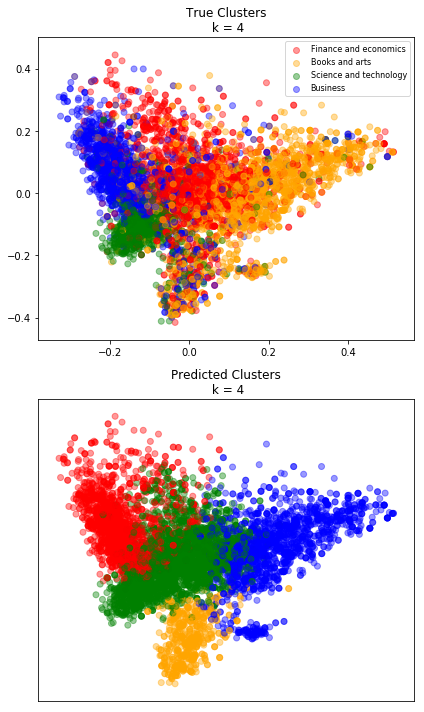

In [13]:
plt.figure(figsize = (6,10))

Fin_econ = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=mycolor[0],alpha = 0.4)
Book_art = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=mycolor[1],alpha = 0.4)
Sci_tech = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=mycolor[2],alpha = 0.4)
Business = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=mycolor[3],alpha = 0.4)

# True Cluster
plt.subplot(211)
colors_p1 = [colordict[category[l]] for l in Economist['T']]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p1, alpha = 0.4)
plt.legend((Fin_econ, Book_art, Sci_tech, Business),
          ('Finance and economics','Books and arts','Science and technology','Business'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =1,
          fontsize = 8)
plt.title('True Clusters\n k = 4')

# Predicted Cluster kmean
plt.subplot(212)
colors_p2 = [colordict[category[l]] for l in km.labels_]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p2, alpha = 0.4)
plt.xticks(())
plt.yticks(())
#plt.legend((Fin_econ, Book_art, Sci_tech, Business),
#          ('Finance and economics','Books and arts','Science and technology','Business'),
#          scatterpoints=1,
#          loc = 'upper right',
#          ncol =1,
#          fontsize = 8)
plt.title('Predicted Clusters\n k = 4')


plt.tight_layout()
plt.show()

## Topic Modeling

In [ ]:
Economist['Tokenized_Words'] = Economist['Article'].apply(lambda x: nltk.word_tokenize(x))
Economist['Normalized_Words'] = Economist['Tokenized_Words'].apply(lambda x: 
                                                                   lucem_illud.normalizeTokens
                                                                   (x, 
                                                                    stopwordLst = lucem_illud.stop_words_basic, 
                                                                    stemmer = lucem_illud.stemmer_basic))

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]


Economist['Reduced_Words'] = Economist['Normalized_Words'].apply(lambda x: dropMissing(x, EconomistTFVectorizer.vocabulary_.keys()))
dictionary = gensim.corpora.Dictionary(Economist['Reduced_Words'])

# secondly, create a corpus -- a list a tuples containing each token and its count
corpus = [dictionary.doc2bow(text) for text in Economist['Reduced_Words']]

# thirdly, serialize the corpus as a file and load it (especially important when the corpus is large)
gensim.corpora.MmCorpus.serialize('Critic.mm', corpus)
criticmm = gensim.corpora.MmCorpus('Critic.mm')

# Inspect the degree to which distinct texts load on different topics. 
# set the num_topics = 10
Economistlda = gensim.models.ldamodel.LdaModel(corpus=criticmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
Economist1Bow = dictionary.doc2bow(Economist['Reduced_Words'][0])
Economist1lda = Economistlda[Economist1Bow]

ldaDF = pandas.DataFrame({
        'name' : Economist['Title'],
        'topics' : [Economistlda[dictionary.doc2bow(l)] for l in Economist['Reduced_Words']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(Economistlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(Economistlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]



In [ ]:

plt.figure(figsize = (15,6))

# Plot the Bar Chart -- topic number is 10
plt.subplot(121)
# Preparation for Bar Chart
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV
N = 10
ind = np.arange(N)
K = Movielda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')  
plt.title('Topics in Movie Kingdom')  
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]  
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))


# Plot the Heat Map
plt.subplot(122)

# Preparation for Heat Map
topicsDict = {}
for topicNum in range(Movielda.num_topics):
    topicWords = [w for w, p in Movielda.show_topic(topicNum, 50)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)  #### **** This is the list of each topics

plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);
plt.gca().invert_yaxis()  # flip the y-axis so the texts are in the order we anticipate
plt.xticks(rotation=90) # rotate the ticks on the x-axis
plt.colorbar(cmap='Blues')  # add a legend
plt.tight_layout()  # fixes margins

plt.tight_layout()
plt.show()

In [ ]:
Fin_econ
Business
Sci_tech
Book_art